##Download data from kaggle

In [1]:
 !pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle


In [3]:
! cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c cisc873-dm-f22-a6

  0% 0.00/3.86M [00:00<?, ?B/s]
100% 3.86M/3.86M [00:00<00:00, 221MB/s]


In [6]:
!unzip /content/cisc873-dm-f22-a6.zip

Archive:  /content/cisc873-dm-f22-a6.zip
  inflating: gcnn-template.ipynb     
  inflating: test_x.sdf              
  inflating: train.sdf               


##Read SDF(structured data format)


In [7]:
import numpy as np   
from tqdm.notebook import tqdm 

In [8]:
# read the sdf file 
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, 
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [9]:
#reading training file
training_set_data = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [10]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(training_set_data, test_size=0.15, random_state=42)     

In [11]:
#reading test file
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [12]:
len(training_set)

21270

In [13]:
len(validation_set)

3754

In [14]:
len(testing_set)

12326

In [15]:
print('training_set >>>>>', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

training_set >>>>> 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


In [16]:
print(training_set[1])

(['O', 'O', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  6],
       [ 1,  2],
       [ 2,  8],
       [ 3,  4],
       [ 3,  5],
       [ 3,  8],
       [ 4,  6],
       [ 4,  9],
       [ 5, 10],
       [ 5, 15],
       [ 5, 16],
       [ 6,  7],
       [ 7, 12],
       [ 7, 17],
       [ 7, 18],
       [ 8, 14],
       [ 9, 11],
       [10, 13],
       [11, 12],
       [11, 19],
       [13, 14],
       [13, 20]]), 0)


##Visualizing Sample

In [17]:
!pip install --quiet networkx

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [19]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [20]:
# visualize function that is used to visualize any sample 
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G



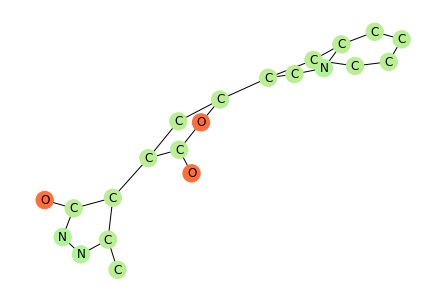

In [21]:
plt.clf()
visualize(training_set[30])

##Preprocessing

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

In [23]:
max_vocab = 500
max_len = 30

all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [24]:
random.seed(0)

In [25]:
#function to prepare the samples in each batch 
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)
    
    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])

In [26]:
# function to generate the batches required by splitting the given data into batches 
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [27]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k_label,v_values in train_batch[0].items(): 
        print(k_label)        
        print(v_values)
        print("Shape is "+str(np.shape(v_values)))
        pass
    print('label', train_batch[1])
    break

data
[8 9 2 2 2 3 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 2 2 3 3 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 5 4 4 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 5 4 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 4 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0]
Shape is (340,)
edges
[[  0   2]
 [  0   3]
 [  0   4]
 [  0   5]
 [  1   5]
 [  1   7]
 [  1   8]
 [  1   9]
 [  2  11]
 [  3  10]
 [  5   6]
 [ 34  44]
 [ 34  45]
 [ 34  46]
 [ 35  47]
 [ 35  50]
 [ 35  51]
 [ 36  48]
 [ 36  52]
 [ 36  53]
 [ 37  49]
 [ 37  54]
 [ 37  55]
 [ 38  64]
 [ 39  65]
 [ 40  

##Helper

In [28]:
!pip install --quiet tf2_gnn

     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 1.3 MB 59.3 MB/s 
     |████████████████████████████████| 383 kB 68.4 MB/s 
     |████████████████████████████████| 135 kB 52.7 MB/s 
     |████████████████████████████████| 172 kB 70.2 MB/s 
     |████████████████████████████████| 4.0 MB 52.4 MB/s 
     |████████████████████████████████| 90 kB 8.1 MB/s 
     |████████████████████████████████| 85 kB 3.0 MB/s 
     |████████████████████████████████| 41 kB 458 kB/s 


In [29]:
from tf2_gnn.layers.gnn import GNN, GNNInput

In [30]:
import tensorflow as tf
from tensorflow.math import segment_mean 
from tensorflow import keras
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.optimizers import Adam
import math


In [31]:
def plt_history_func(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # plot the Model AUC accuracy through the training and validation
  ax1.plot(history.history['auc'])
  ax1.plot(history.history['val_auc'])
  ax1.set_title('Model AUC')
  ax1.set_ylabel('AUC value')
  ax1.set_xlabel('Number of epochs')
  ax1.legend(['tr_AUC', 'val_AUC'], loc='lower right')

  # plot the Model loss through the training and validation
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('Model loss')
  ax2.set_ylabel('Loss value')
  ax2.set_xlabel('Number of epochs')
  ax2.legend(['tr_loss', 'val_loss'], loc='upper right')

##Trial_1 Using Graph Neural Networks (GNN)

In [32]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T1.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

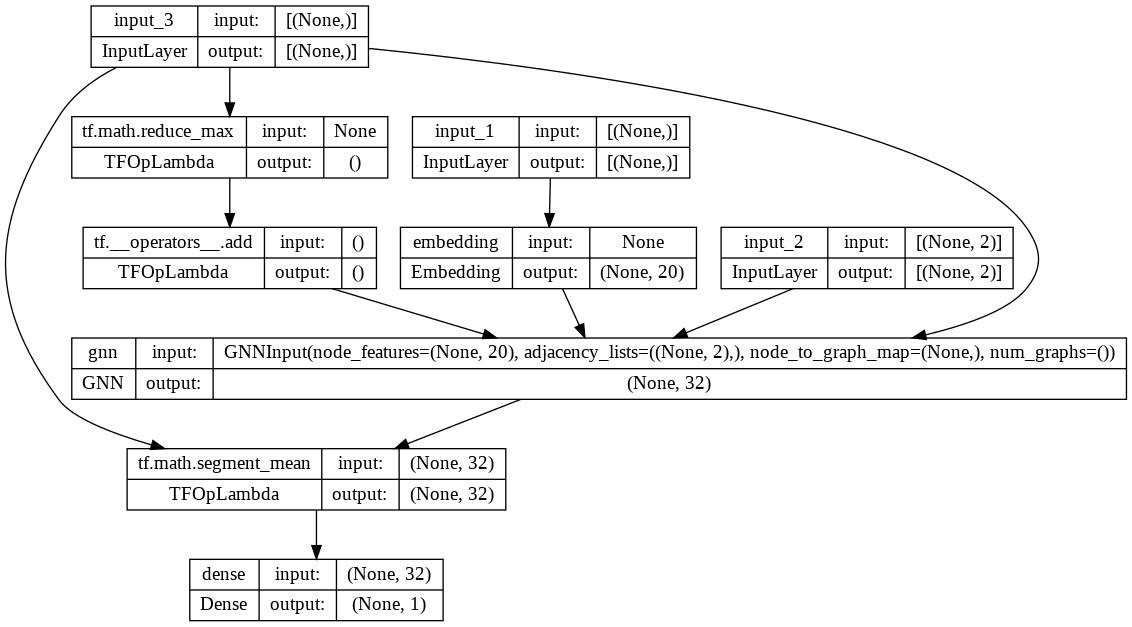

In [33]:
tf.keras.utils.plot_model(model_T1, show_shapes=True)

In [34]:
model_T1.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [35]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T1 = model_T1.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/loca

665/665 [==============================] - 28s 37ms/step - loss: 0.2440 - auc: 0.4958 - val_loss: 0.2003 - val_auc: 0.6474
Epoch 2/30
665/665 [==============================] - 24s 36ms/step - loss: 0.1879 - auc: 0.6437 - val_loss: 0.1898 - val_auc: 0.6848
Epoch 3/30
665/665 [==============================] - 24s 36ms/step - loss: 0.1845 - auc: 0.6620 - val_loss: 0.1863 - val_auc: 0.7228
Epoch 4/30
665/665 [==============================] - 23s 35ms/step - loss: 0.1826 - auc: 0.6789 - val_loss: 0.1757 - val_auc: 0.7275
Epoch 5/30
665/665 [==============================] - 24s 35ms/step - loss: 0.1818 - auc: 0.6784 - val_loss: 0.1958 - val_auc: 0.7254
Epoch 6/30
665/665 [==============================] - 23s 35ms/step - loss: 0.1798 - auc: 0.6879 - val_loss: 0.1817 - val_auc: 0.7126
Epoch 7/30
665/665 [==============================] - 25s 37ms/step - loss: 0.1783 - auc: 0.7063 - val_loss: 0.1887 - val_auc: 0.7185
Epoch 8/30
665/665 [==============================] - 24s 36ms/step - los

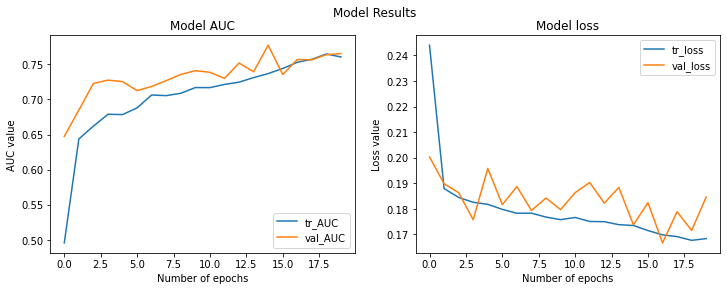

In [36]:
plt_history_func(history_T1)

In [37]:
y_pred = model_T1.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 5s 13ms/step


In [38]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T1.csv')

##Trial_2 Using Gated Graph Neural Network (GGNN)

In [39]:
from tf2_gnn.layers.message_passing import ggnn

In [40]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "GGNN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T2.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []      

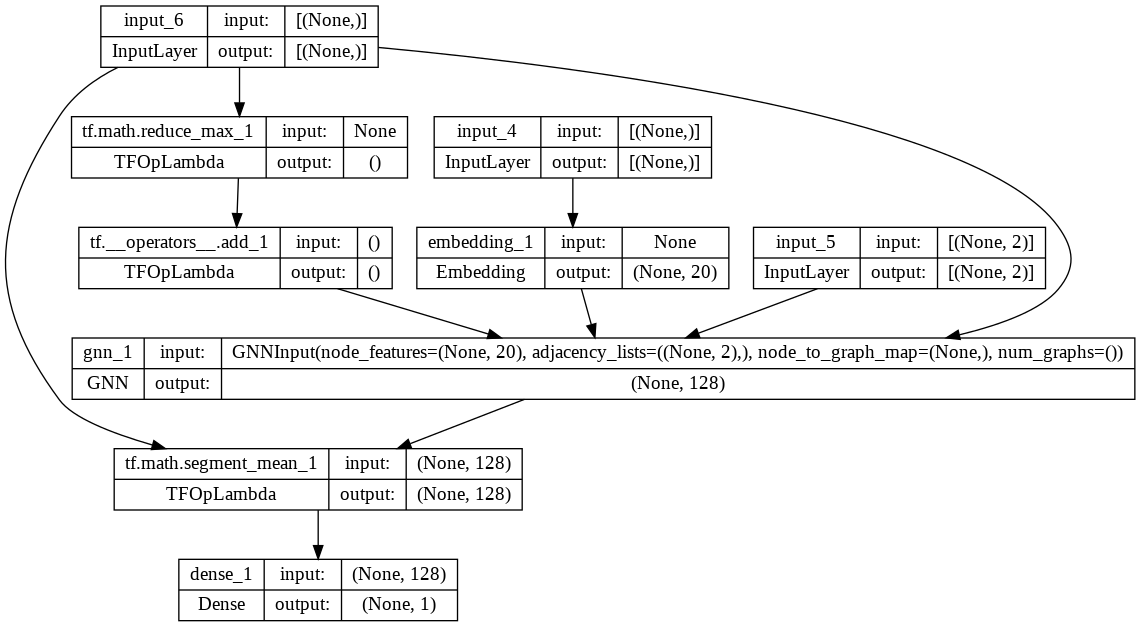

In [41]:
tf.keras.utils.plot_model(model_T2, show_shapes=True)

In [42]:
model_T2.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [44]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
history_T2 = model_T2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/15
665/665 [==============================] - 175s 264ms/step - loss: 0.1804 - auc: 0.6961 - val_loss: 0.1798 - val_auc: 0.7174
Epoch 2/15
665/665 [==============================] - 174s 262ms/step - loss: 0.1793 - auc: 0.6988 - val_loss: 0.1841 - val_auc: 0.7268
Epoch 3/15
665/665 [==============================] - 173s 260ms/step - loss: 0.1790 - auc: 0.6971 - val_loss: 0.1792 - val_auc: 0.7401
Epoch 4/15
665/665 [==============================] - 173s 261ms/step - loss: 0.1776 - auc: 0.7026 - val_loss: 0.1796 - val_auc: 0.7399
Epoch 5/15
665/665 [==============================] - 168s 253ms/step - loss: 0.1793 - auc: 0.6912 - val_loss: 0.1803 - val_auc: 0.7246
Epoch 6/15
665/665 [==============================] - 169s 254ms/step - loss: 0.1803 - auc: 0.6862 - val_loss: 0.1915 - val_auc: 0.6838
Epoch 7/15
665/665 [==============================] - 177s 266ms/step - loss: 0.1802 - auc: 0.6868 - val_loss: 0.1856 - val_auc: 0.7279
Epoch 8/15
665/665 [============================

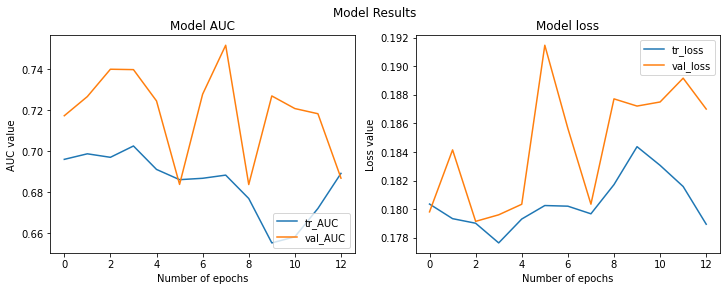

In [45]:
plt_history_func(history_T2)

In [46]:
y_pred = model_T2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 34s 88ms/step


In [47]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T2.csv')

##Trial_3 Using Relational Graph Convolutional Networks(RGCN)

In [48]:
from tf2_gnn.layers.message_passing import rgcn

In [49]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGCN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T3.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []      

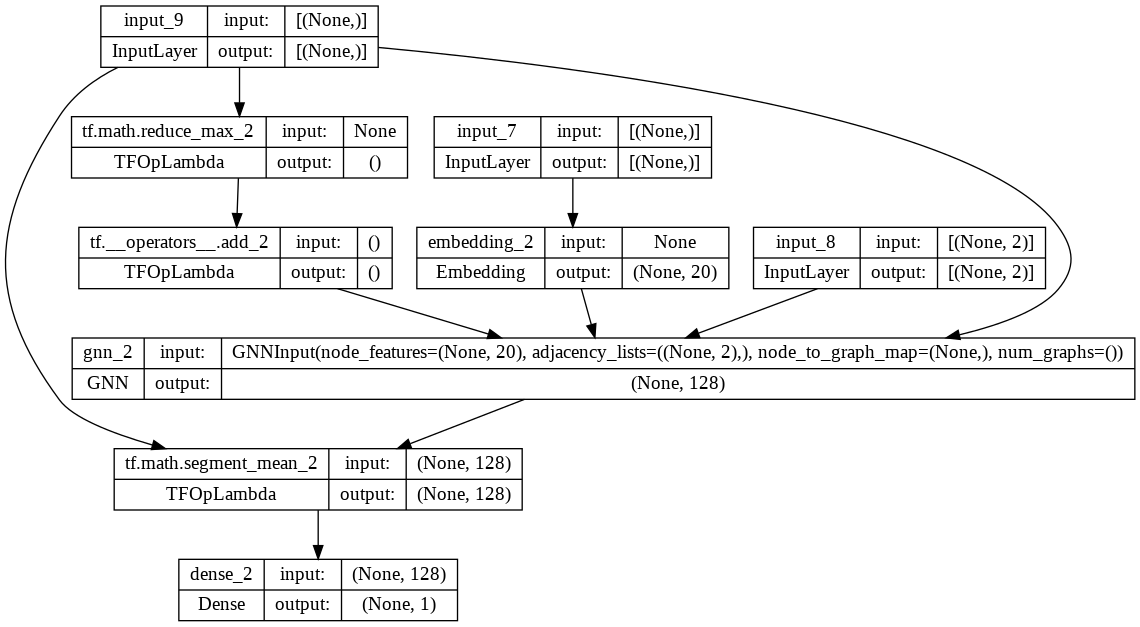

In [50]:
tf.keras.utils.plot_model(model_T3, show_shapes=True)

In [51]:
model_T3.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [52]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T3 = model_T3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large 

665/665 [==============================] - 88s 128ms/step - loss: 0.2320 - auc: 0.5607 - val_loss: 0.1914 - val_auc: 0.6832
Epoch 2/20
665/665 [==============================] - 85s 128ms/step - loss: 0.1902 - auc: 0.6621 - val_loss: 0.1847 - val_auc: 0.7019
Epoch 3/20
665/665 [==============================] - 86s 129ms/step - loss: 0.1830 - auc: 0.6946 - val_loss: 0.1800 - val_auc: 0.7323
Epoch 4/20
665/665 [==============================] - 77s 116ms/step - loss: 0.1799 - auc: 0.7010 - val_loss: 0.1828 - val_auc: 0.7346
Epoch 5/20
665/665 [==============================] - 77s 116ms/step - loss: 0.1760 - auc: 0.7227 - val_loss: 0.1773 - val_auc: 0.7524
Epoch 6/20
665/665 [==============================] - 80s 120ms/step - loss: 0.1748 - auc: 0.7240 - val_loss: 0.1788 - val_auc: 0.7501
Epoch 7/20
665/665 [==============================] - 78s 118ms/step - loss: 0.1717 - auc: 0.7422 - val_loss: 0.1761 - val_auc: 0.7487
Epoch 8/20
665/665 [==============================] - 81s 122ms/st

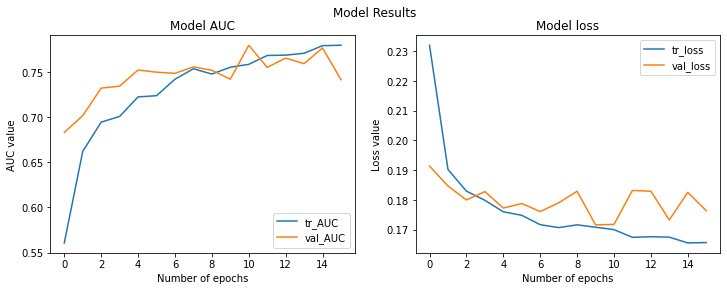

In [53]:
plt_history_func(history_T3)

In [54]:
y_pred = model_T3.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 14s 36ms/step


In [55]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T3.csv')

##Trial_4 Using Relational Graph Attention Networks(RGAN)

In [59]:
from tf2_gnn.layers.message_passing import rgat

In [60]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGAT"
params["num_heads"] = 4
params["num_layers"] = 8
params["dense_every_num_layers"] = 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T4.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []      

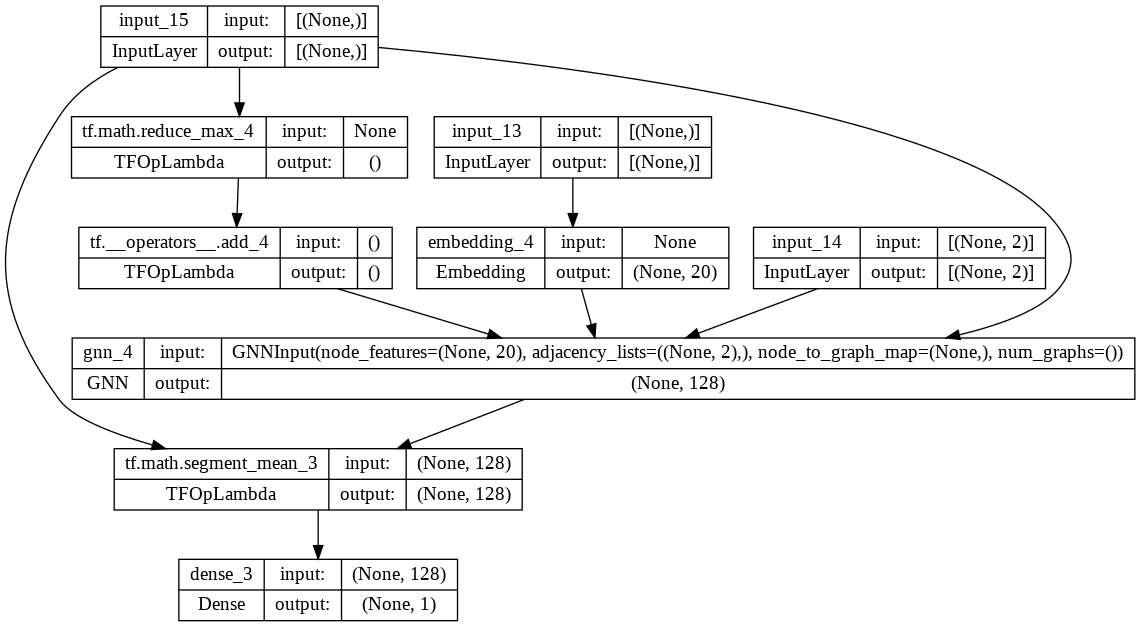

In [61]:
tf.keras.utils.plot_model(model_T4, show_shapes=True)

In [62]:
model_T4.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [63]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
history_T4 = model_T4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib

665/665 [==============================] - 228s 325ms/step - loss: 0.2294 - auc: 0.5269 - val_loss: 0.1902 - val_auc: 0.6698
Epoch 2/20
665/665 [==============================] - 209s 315ms/step - loss: 0.1919 - auc: 0.6351 - val_loss: 0.1871 - val_auc: 0.7240
Epoch 3/20
665/665 [==============================] - 217s 326ms/step - loss: 0.1882 - auc: 0.6546 - val_loss: 0.1894 - val_auc: 0.6994
Epoch 4/20
665/665 [==============================] - 219s 330ms/step - loss: 0.1885 - auc: 0.6475 - val_loss: 0.1942 - val_auc: 0.7134
Epoch 5/20
665/665 [==============================] - 219s 330ms/step - loss: 0.1832 - auc: 0.6742 - val_loss: 0.1804 - val_auc: 0.7291
Epoch 6/20
665/665 [==============================] - 218s 329ms/step - loss: 0.1798 - auc: 0.6951 - val_loss: 0.1825 - val_auc: 0.7444
Epoch 7/20
665/665 [==============================] - 214s 322ms/step - loss: 0.1777 - auc: 0.7072 - val_loss: 0.1796 - val_auc: 0.7626
Epoch 8/20
665/665 [==============================] - 214s 

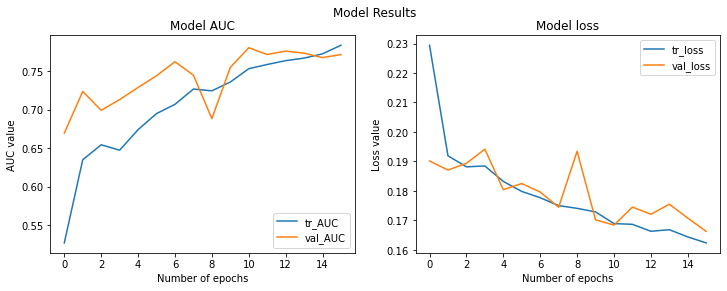

In [64]:
plt_history_func(history_T4)

In [65]:
y_pred = model_T4.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 36s 90ms/step


In [66]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T4.csv')

##Trial_5 Using Relational Graph Isomorphism Networks(RGIN)

In [69]:
from tf2_gnn.layers.message_passing import rgin

In [70]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGIN"
params["num_aggr_MLP_hidden_layers"] = 1
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T5 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T5.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []      

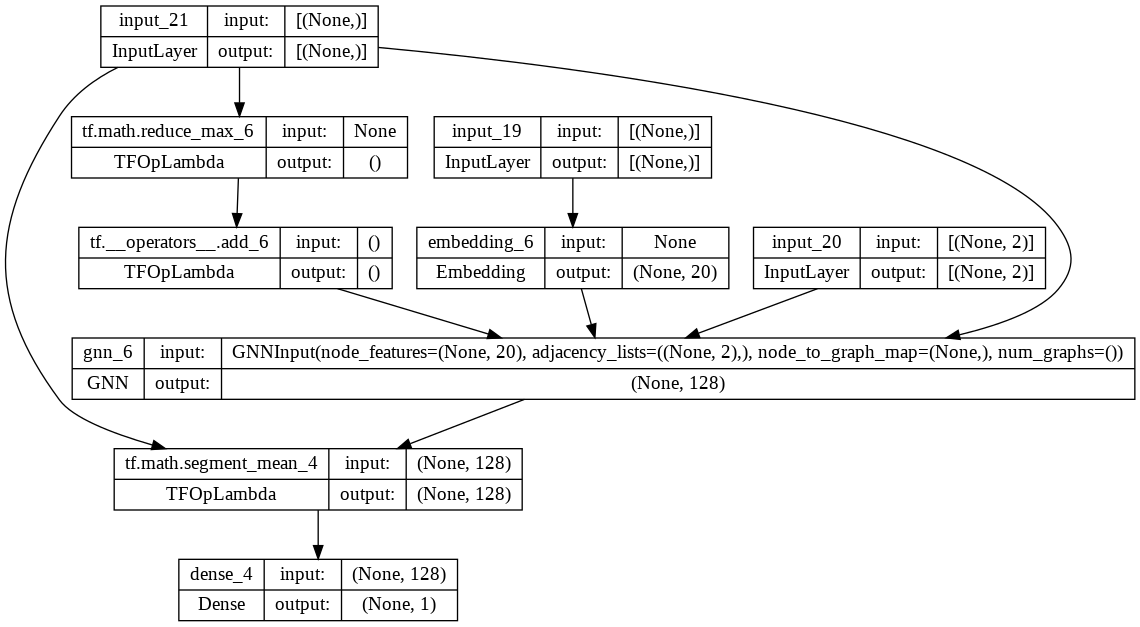

In [71]:
tf.keras.utils.plot_model(model_T5, show_shapes=True)

In [72]:
model_T5.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [73]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T5 = model_T5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large 

665/665 [==============================] - 98s 144ms/step - loss: 0.2290 - auc: 0.5549 - val_loss: 0.1913 - val_auc: 0.6883
Epoch 2/20
665/665 [==============================] - 98s 148ms/step - loss: 0.1978 - auc: 0.6277 - val_loss: 0.2010 - val_auc: 0.6721
Epoch 3/20
665/665 [==============================] - 95s 143ms/step - loss: 0.1958 - auc: 0.6451 - val_loss: 0.1915 - val_auc: 0.6676
Epoch 4/20
665/665 [==============================] - 97s 146ms/step - loss: 0.1897 - auc: 0.6691 - val_loss: 0.1884 - val_auc: 0.7023
Epoch 5/20
665/665 [==============================] - 96s 145ms/step - loss: 0.2022 - auc: 0.6150 - val_loss: 0.2132 - val_auc: 0.6100
Epoch 6/20
665/665 [==============================] - 97s 146ms/step - loss: 0.1908 - auc: 0.6556 - val_loss: 0.1793 - val_auc: 0.7440
Epoch 7/20
665/665 [==============================] - 95s 143ms/step - loss: 0.1809 - auc: 0.6979 - val_loss: 0.1772 - val_auc: 0.7368
Epoch 8/20
665/665 [==============================] - 93s 140ms/st

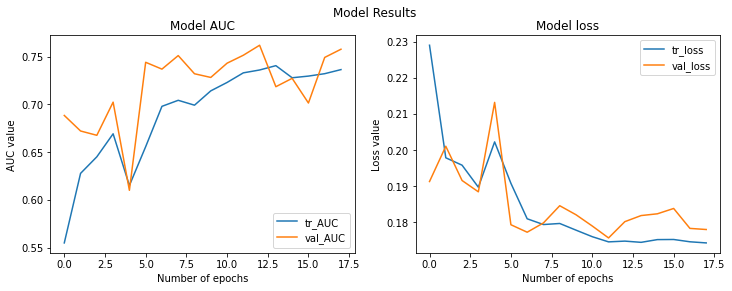

In [74]:
plt_history_func(history_T5)

In [75]:
y_pred = model_T5.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 17s 44ms/step


In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T5.csv')

##Trial_6 Using Graph Neural Network with Edge MLPs

In [82]:
from tf2_gnn.layers.message_passing import gnn_edge_mlp

In [83]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "GNN_Edge_MLP"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T6 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T6.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []      

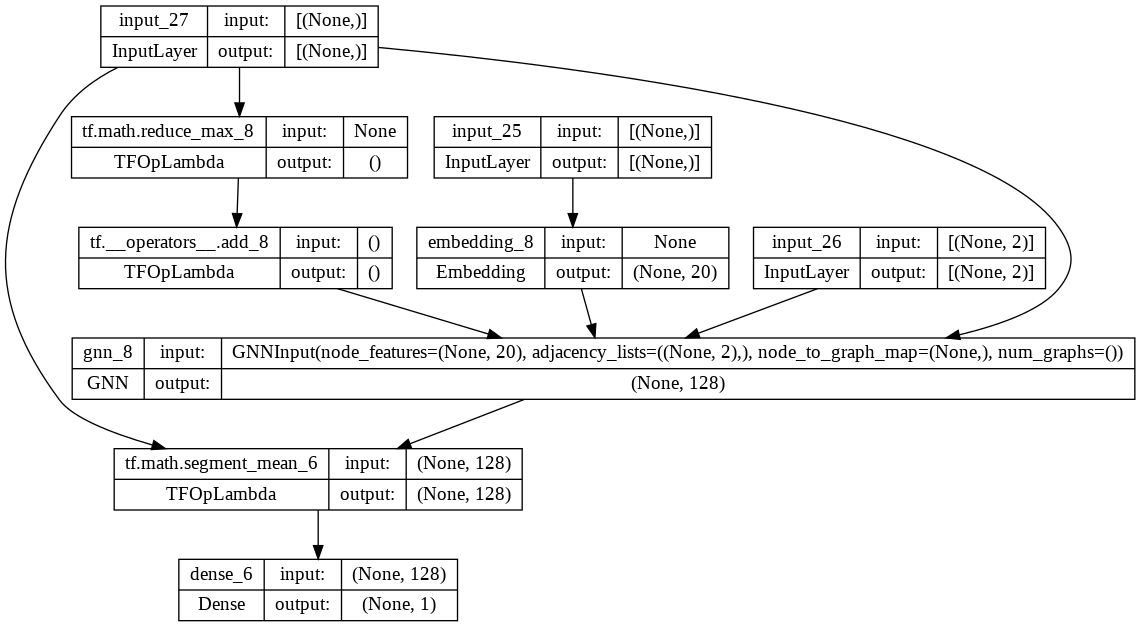

In [84]:
tf.keras.utils.plot_model(model_T6, show_shapes=True)

In [85]:
model_T6.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [86]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
history_T6 = model_T6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Cast:0

665/665 [==============================] - 94s 138ms/step - loss: 0.2328 - auc: 0.5584 - val_loss: 0.1889 - val_auc: 0.6806
Epoch 2/20
665/665 [==============================] - 88s 132ms/step - loss: 0.1894 - auc: 0.6590 - val_loss: 0.1982 - val_auc: 0.6955
Epoch 3/20
665/665 [==============================] - 77s 115ms/step - loss: 0.1846 - auc: 0.6823 - val_loss: 0.1856 - val_auc: 0.7114
Epoch 4/20
665/665 [==============================] - 75s 113ms/step - loss: 0.1808 - auc: 0.7008 - val_loss: 0.1863 - val_auc: 0.7366
Epoch 5/20
665/665 [==============================] - 75s 113ms/step - loss: 0.1798 - auc: 0.7079 - val_loss: 0.1775 - val_auc: 0.7212
Epoch 6/20
665/665 [==============================] - 77s 117ms/step - loss: 0.1748 - auc: 0.7317 - val_loss: 0.1910 - val_auc: 0.7114
Epoch 7/20
665/665 [==============================] - 88s 132ms/step - loss: 0.1746 - auc: 0.7292 - val_loss: 0.1786 - val_auc: 0.7653
Epoch 8/20
665/665 [==============================] - 85s 127ms/st

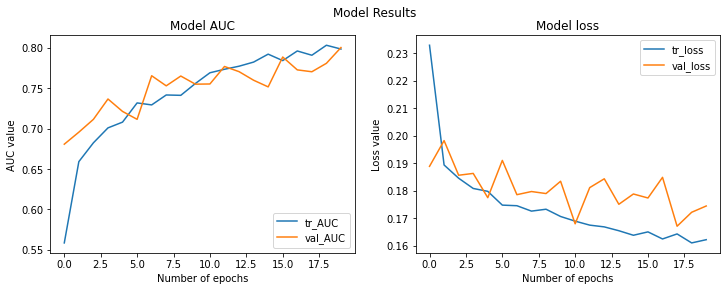

In [87]:
plt_history_func(history_T6)

In [88]:
y_pred = model_T6.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 13s 34ms/step


In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T6.csv')

##Trial_7 Using Graph Neural Networks with Feature-wise Linear Modulation

In [90]:
from tf2_gnn.layers.message_passing import GNN_FiLM

In [91]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = 'GNN_FiLM'
#params["num_layers"] = 4
params["num_heads"] = 3
params['film_parameter_MLP_hidden_layers'] = 12
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T7 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T7.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []      

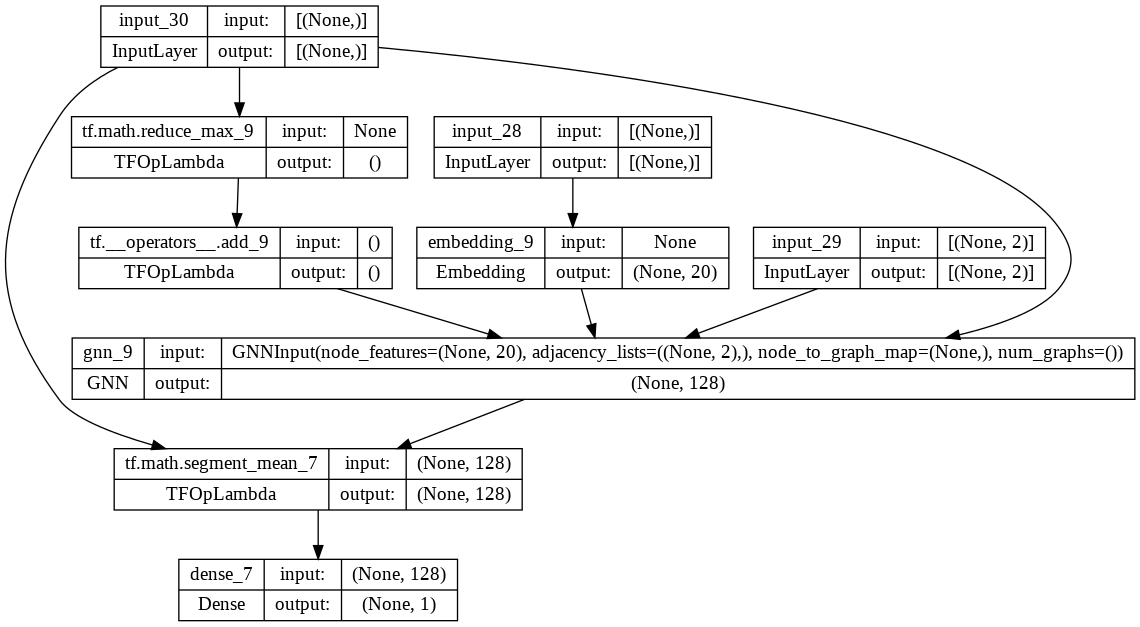

In [92]:
tf.keras.utils.plot_model(model_T7, show_shapes=True)

In [93]:
model_T7.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [94]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T7 = model_T7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consu

665/665 [==============================] - 346s 513ms/step - loss: 0.2520 - auc: 0.5007 - val_loss: 0.1970 - val_auc: 0.6153
Epoch 2/20
665/665 [==============================] - 336s 506ms/step - loss: 0.2137 - auc: 0.5928 - val_loss: 0.1983 - val_auc: 0.6820
Epoch 3/20
665/665 [==============================] - 338s 509ms/step - loss: 0.1897 - auc: 0.6668 - val_loss: 0.1781 - val_auc: 0.7432
Epoch 4/20
665/665 [==============================] - 334s 502ms/step - loss: 0.1861 - auc: 0.6863 - val_loss: 0.1820 - val_auc: 0.7368
Epoch 5/20
665/665 [==============================] - 332s 499ms/step - loss: 0.1835 - auc: 0.6949 - val_loss: 0.1991 - val_auc: 0.7591
Epoch 6/20
665/665 [==============================] - 346s 520ms/step - loss: 0.1818 - auc: 0.7051 - val_loss: 0.1686 - val_auc: 0.7878
Epoch 7/20
665/665 [==============================] - 354s 532ms/step - loss: 0.1806 - auc: 0.7075 - val_loss: 0.1771 - val_auc: 0.7674
Epoch 8/20
665/665 [==============================] - 348s 

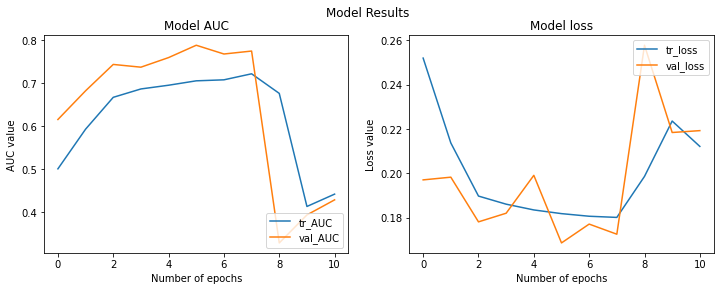

In [95]:
plt_history_func(history_T7)

In [96]:
y_pred = model_T7.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 60s 154ms/step


In [97]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T7.csv')

#with Oversampling

In [98]:
np.unique(np.array(training_set_data)[:,2],return_counts=True)

<ipython-input-98-f90e383f58bc>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set_data)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218]))

<ipython-input-99-aabf22cf7bc1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.countplot(np.array(training_set_data)[:,2])
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


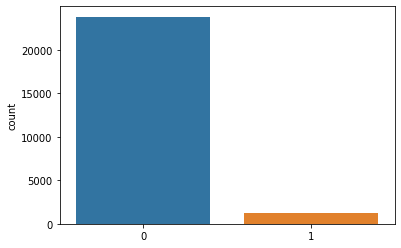

In [99]:
import seaborn as sns
sns.countplot(np.array(training_set_data)[:,2])

there is unbalance in the weights between the two classes, and we need to make upsampling for the class 1

In [100]:
import pandas as pd
from sklearn.utils import resample

#read the training data as a dataframe
df = pd.DataFrame(training_set_data,columns=['Nodes','Edges','Labels']) 
df_majority = df[df['Labels']==0]  #data with majority class
df_minority = df[df['Labels']==1]  #data with maniority class

print('Shape of Unbalanced Data before Upsampling:')
print(df_majority.shape)
print(df_minority .shape)
print('\n')

# Upsample minority class 
df_minority_upsampled = resample(df_minority,
                                  # sample with replacement 
                                 replace=True, 
                                 # to match majority class                 
                                 n_samples=len(df_majority),
                                  # reproducible results     
                                 random_state=42)               

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print('New class counts after Upsampling:')
df_upsampled['Labels'].value_counts()

Shape of Unbalanced Data before Upsampling:
(23806, 3)
(1218, 3)


New class counts after Upsampling:


0    23806
1    23806
Name: Labels, dtype: int64

In [101]:
training_set_sampled= df_upsampled.to_numpy()

In [102]:
training_set, validation_set = train_test_split(training_set_sampled, test_size=0.15)

##Visualizing Sample

In [103]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [104]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [105]:
# visualize function that is used to visualize any sample 
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G



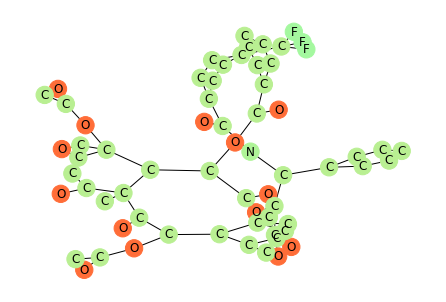

In [106]:
plt.clf()
visualize(training_set[30])

##Preprocessing

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

In [108]:
max_vocab = 500
max_len = 30

all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [109]:
random.seed(0)

In [110]:
#function to prepare the samples in each batch 
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)
    
    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])

In [111]:
# function to generate the batches required by splitting the given data into batches 
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [112]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k_label,v_values in train_batch[0].items(): 
        print(k_label)        
        print(v_values)
        print("Shape is "+str(np.shape(v_values)))
        pass
    print('label', train_batch[1])
    break

data
[7 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 3 3 3 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 4 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 6 6 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

##Trial_8 Using Graph Neural Networks (GNN) 

In [113]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T8 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T8.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           []      

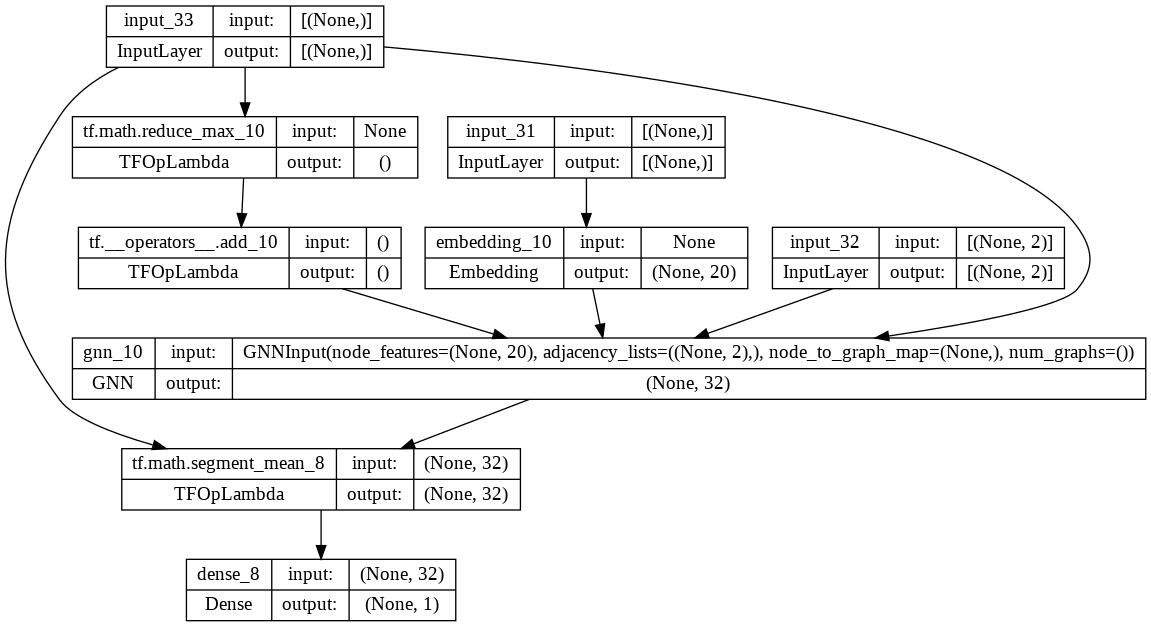

In [114]:
tf.keras.utils.plot_model(model_T8, show_shapes=True)

In [115]:
model_T8.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [116]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T8 = model_T8.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],
 
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large am

1265/1265 [==============================] - 55s 41ms/step - loss: 0.6257 - auc: 0.7066 - val_loss: 0.6086 - val_auc: 0.7426
Epoch 2/20
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5977 - auc: 0.7408 - val_loss: 0.5867 - val_auc: 0.7581
Epoch 3/20
1265/1265 [==============================] - 54s 43ms/step - loss: 0.5788 - auc: 0.7596 - val_loss: 0.5708 - val_auc: 0.7709
Epoch 4/20
1265/1265 [==============================] - 56s 44ms/step - loss: 0.5664 - auc: 0.7726 - val_loss: 0.5447 - val_auc: 0.7951
Epoch 5/20
1265/1265 [==============================] - 57s 45ms/step - loss: 0.5510 - auc: 0.7899 - val_loss: 0.5305 - val_auc: 0.8155
Epoch 6/20
1265/1265 [==============================] - 59s 46ms/step - loss: 0.5398 - auc: 0.8013 - val_loss: 0.5241 - val_auc: 0.8197
Epoch 7/20
1265/1265 [==============================] - 64s 50ms/step - loss: 0.5303 - auc: 0.8108 - val_loss: 0.5082 - val_auc: 0.8291
Epoch 8/20
1265/1265 [==============================] - 60s

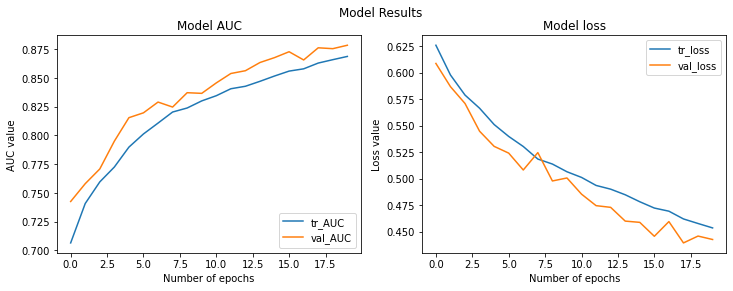

In [117]:
plt_history_func(history_T8)

In [118]:
y_pred = model_T8.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 5s 13ms/step


In [119]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T8.csv')

##Trial_9 Using Gated Graph Neural Network (GGNN)

In [120]:
from tf2_gnn.layers.message_passing import ggnn

In [121]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "GGNN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T9 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T9.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []    

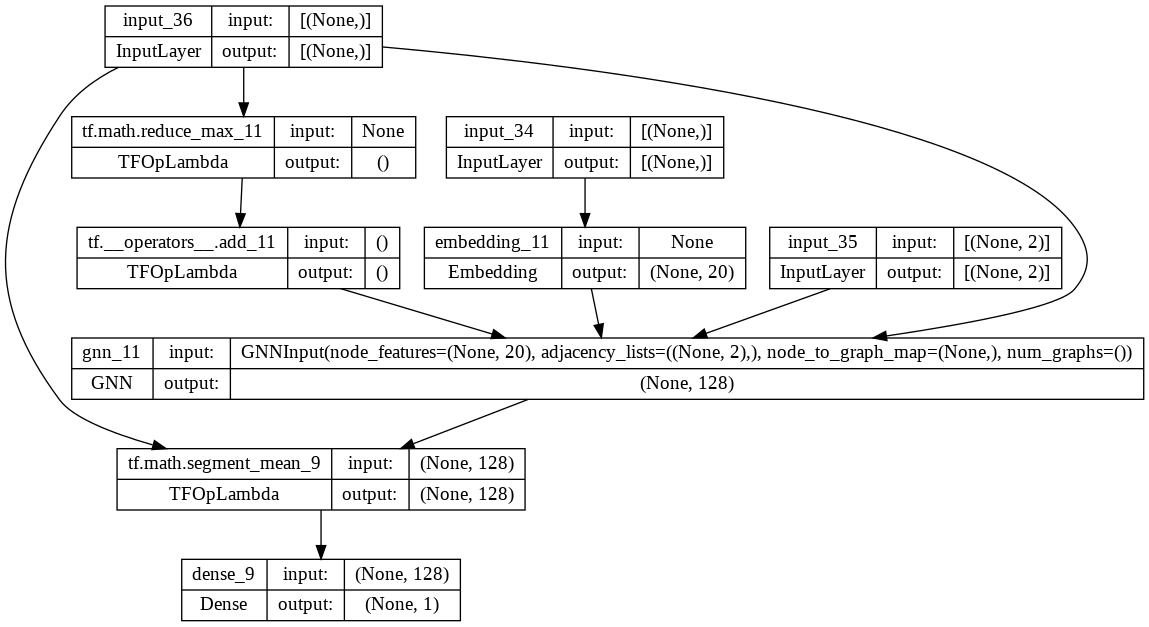

In [122]:
tf.keras.utils.plot_model(model_T9, show_shapes=True)

In [123]:
model_T9.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [124]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T9 = model_T9.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor 

1265/1265 [==============================] - 377s 295ms/step - loss: 0.6233 - auc: 0.7127 - val_loss: 0.5782 - val_auc: 0.7737
Epoch 2/15
1265/1265 [==============================] - 376s 298ms/step - loss: 0.5564 - auc: 0.7891 - val_loss: 0.5500 - val_auc: 0.7956
Epoch 3/15
1265/1265 [==============================] - 392s 309ms/step - loss: 0.5196 - auc: 0.8216 - val_loss: 0.5178 - val_auc: 0.8337
Epoch 4/15
1265/1265 [==============================] - 399s 316ms/step - loss: 0.4871 - auc: 0.8469 - val_loss: 0.4703 - val_auc: 0.8624
Epoch 5/15
1265/1265 [==============================] - 389s 307ms/step - loss: 0.4496 - auc: 0.8721 - val_loss: 0.4249 - val_auc: 0.8937
Epoch 6/15
1265/1265 [==============================] - 396s 313ms/step - loss: 0.4190 - auc: 0.8904 - val_loss: 0.4106 - val_auc: 0.9033
Epoch 7/15
1265/1265 [==============================] - 389s 307ms/step - loss: 0.3794 - auc: 0.9113 - val_loss: 0.3417 - val_auc: 0.9291
Epoch 8/15
1265/1265 [=======================

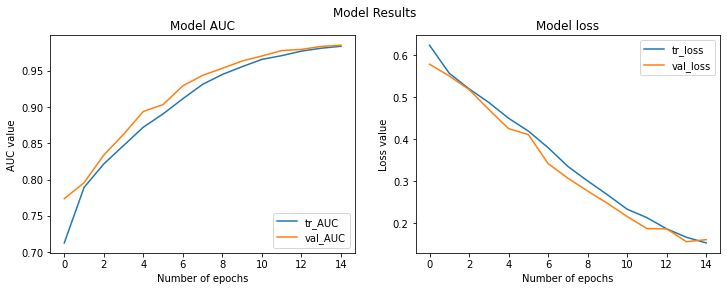

In [125]:
plt_history_func(history_T9)

In [126]:
y_pred = model_T9.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 33s 86ms/step


In [127]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T9.csv')

##Trial_10 Using Relational Graph Convolutional Networks(RGCN)

In [128]:
from tf2_gnn.layers.message_passing import rgcn

In [129]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGCN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T10 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T10.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           [

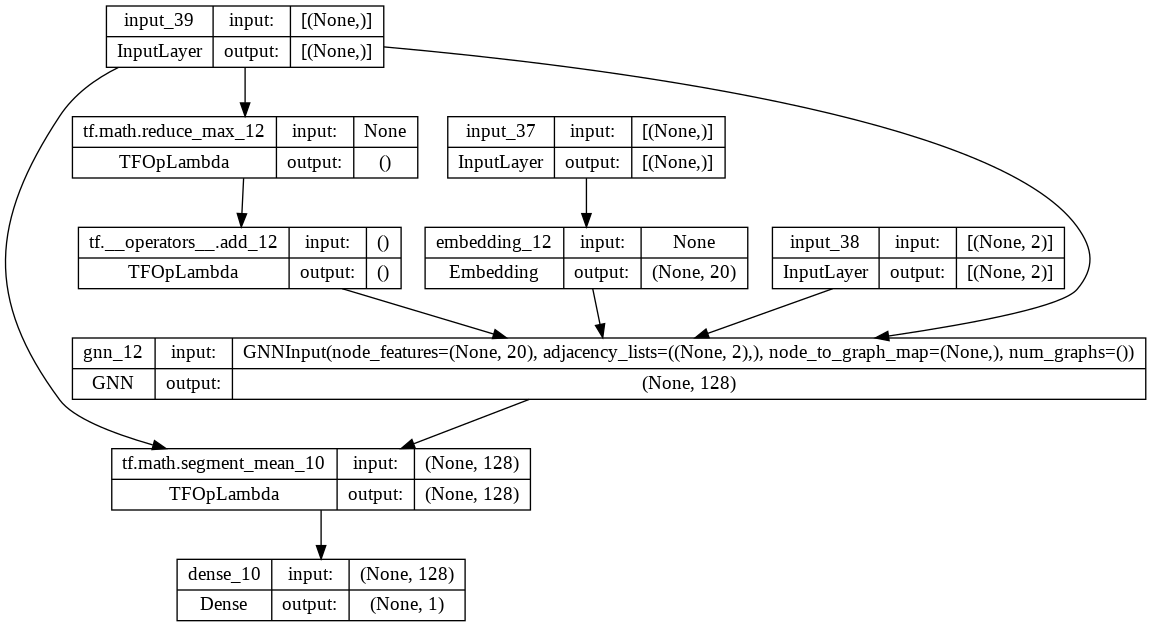

In [130]:
tf.keras.utils.plot_model(model_T10, show_shapes=True)

In [131]:
model_T10.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [132]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T10 = model_T10.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large 

1265/1265 [==============================] - 218s 170ms/step - loss: 0.6208 - auc: 0.7156 - val_loss: 0.5897 - val_auc: 0.7663
Epoch 2/20
1265/1265 [==============================] - 190s 150ms/step - loss: 0.5847 - auc: 0.7595 - val_loss: 0.5661 - val_auc: 0.7825
Epoch 3/20
1265/1265 [==============================] - 183s 145ms/step - loss: 0.5648 - auc: 0.7788 - val_loss: 0.5504 - val_auc: 0.7960
Epoch 4/20
1265/1265 [==============================] - 199s 157ms/step - loss: 0.5403 - auc: 0.8019 - val_loss: 0.6355 - val_auc: 0.7831
Epoch 5/20
1265/1265 [==============================] - 201s 159ms/step - loss: 0.5188 - auc: 0.8220 - val_loss: 0.4938 - val_auc: 0.8427
Epoch 6/20
1265/1265 [==============================] - 177s 140ms/step - loss: 0.4918 - auc: 0.8429 - val_loss: 0.4859 - val_auc: 0.8547
Epoch 7/20
1265/1265 [==============================] - 175s 138ms/step - loss: 0.4678 - auc: 0.8601 - val_loss: 0.4515 - val_auc: 0.8718
Epoch 8/20
1265/1265 [=======================

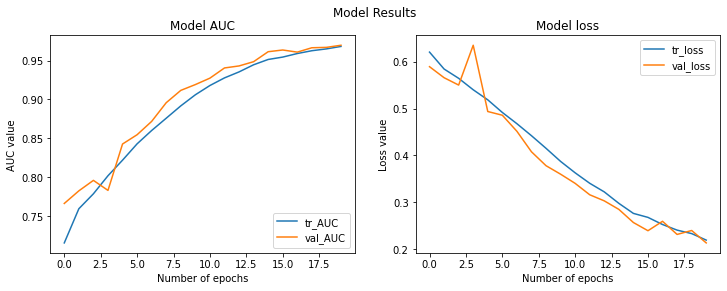

In [133]:
plt_history_func(history_T10)

In [134]:
y_pred = model_T10.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 14s 34ms/step


In [135]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T10.csv')

##Trial_11 Using Relational Graph Attention Networks(RGAN)

In [141]:
from tf2_gnn.layers.message_passing import rgat

In [142]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGAT"
params["num_heads"] = 4
params["num_layers"] = 8
params["dense_every_num_layers"] = 8
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T11 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T11.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_15/StatefulPartitionedCall:0', description="created by layer 'gnn_15'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None,)]            0           [

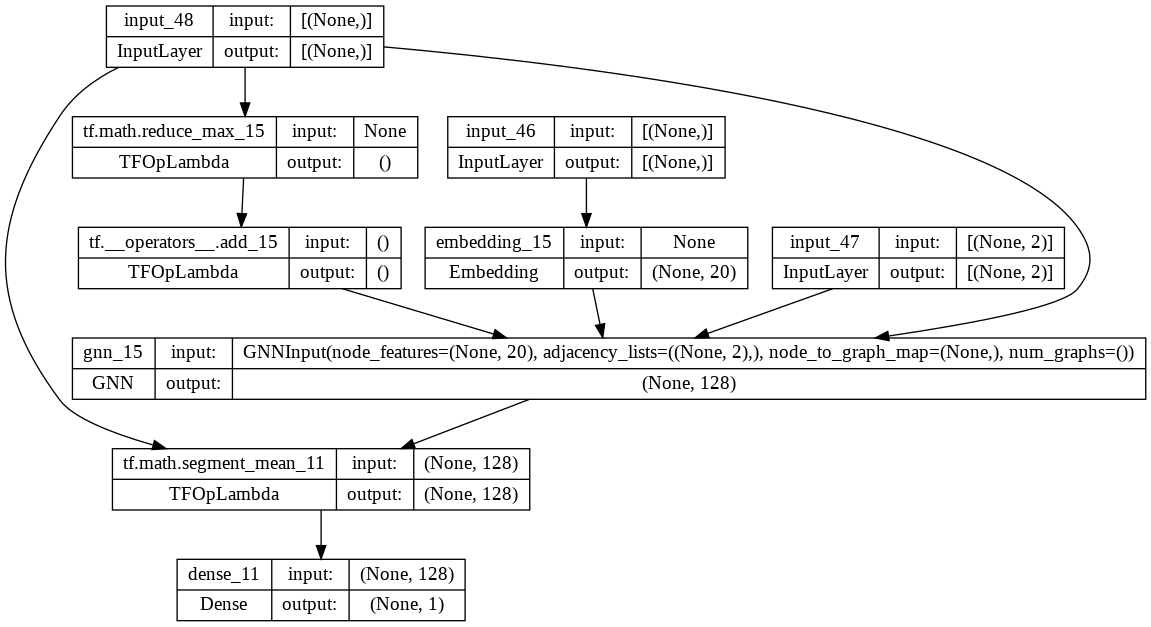

In [143]:
tf.keras.utils.plot_model(model_T11, show_shapes=True)

In [144]:
model_T11.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T11 = model_T11.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/10
1265/1265 [==============================] - 477s 377ms/step - loss: 0.5459 - auc: 0.7988 - val_loss: 0.5457 - val_auc: 0.8024
Epoch 2/10
1265/1265 [==============================] - 485s 384ms/step - loss: 0.5084 - auc: 0.8308 - val_loss: 0.4871 - val_auc: 0.8486
Epoch 3/10
1265/1265 [==============================] - 486s 384ms/step - loss: 0.4754 - auc: 0.8546 - val_loss: 0.4492 - val_auc: 0.8727
Epoch 4/10
1265/1265 [==============================] - 492s 389ms/step - loss: 0.4438 - auc: 0.8745 - val_loss: 0.4290 - val_auc: 0.8914
Epoch 5/10
1265/1265 [==============================] - 493s 390ms/step - loss: 0.4179 - auc: 0.8905 - val_loss: 0.3919 - val_auc: 0.9057
Epoch 6/10
1265/1265 [==============================] - 486s 384ms/step - loss: 0.3816 - auc: 0.9087 - val_loss: 0.3634 - val_auc: 0.9190
Epoch 7/10
1265/1265 [==============================] - 477s 377ms/step - loss: 0.3547 - auc: 0.9215 - val_loss: 0.3363 - val_auc: 0.9316
Epoch 8/10
  87/1265 [=>..........

In [ ]:
plt_history_func(history_T11)

In [ ]:
y_pred = model_T11.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T11.csv')

##Trial_12 Using Relational Graph Isomorphism Networks(RGIN)

In [ ]:
from tf2_gnn.layers.message_passing import rgin

In [ ]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "RGIN"
params["num_aggr_MLP_hidden_layers"] = 1
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T12 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T12.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

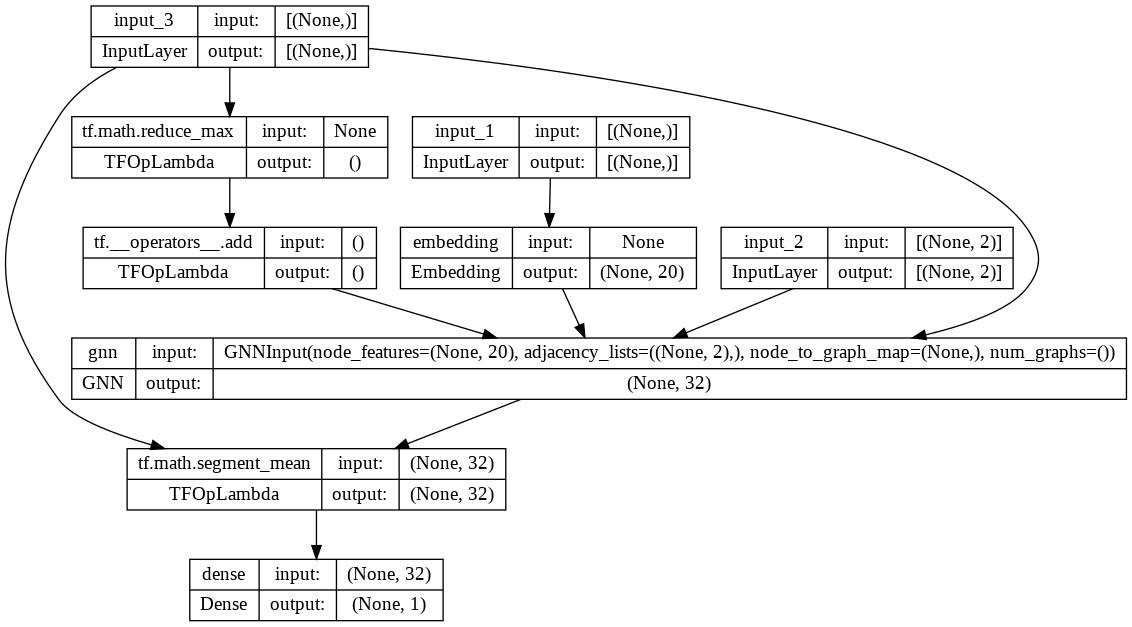

In [ ]:
tf.keras.utils.plot_model(model_T12, show_shapes=True)

In [ ]:
model_T12.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
%%time
history_T12 = model_T12.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/loca

1330/1330 [==============================] - 20s 11ms/step - loss: 0.2300 - auc: 0.5059 - val_loss: 0.1964 - val_auc: 0.6349
Epoch 2/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1911 - auc: 0.6315 - val_loss: 0.1906 - val_auc: 0.6799
Epoch 3/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1860 - auc: 0.6641 - val_loss: 0.1888 - val_auc: 0.6883
Epoch 4/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1828 - auc: 0.6790 - val_loss: 0.1802 - val_auc: 0.7126
Epoch 5/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1827 - auc: 0.6756 - val_loss: 0.1903 - val_auc: 0.7095
Epoch 6/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1809 - auc: 0.6863 - val_loss: 0.1893 - val_auc: 0.7105
Epoch 7/10
1330/1330 [==============================] - 18s 13ms/step - loss: 0.1789 - auc: 0.6961 - val_loss: 0.1861 - val_auc: 0.7237
Epoch 8/10
1330/1330 [==============================] - 14s

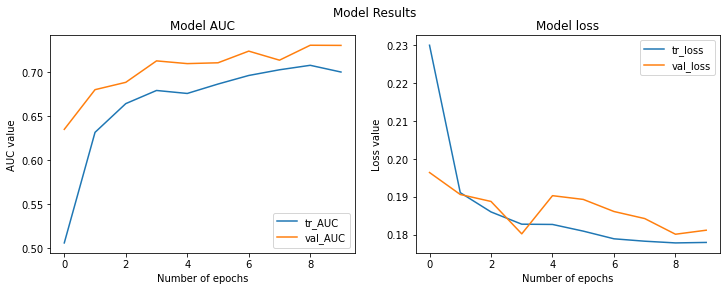

In [ ]:
plt_history_func(history_T12)

In [ ]:
y_pred = model_T12.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T5.csv')

##Trial_13 Using Graph Neural Network with Edge MLPs

In [ ]:
from tf2_gnn.layers.message_passing import gnn_edge_mlp

In [ ]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "GNN_Edge_MLP"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T13 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T13.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

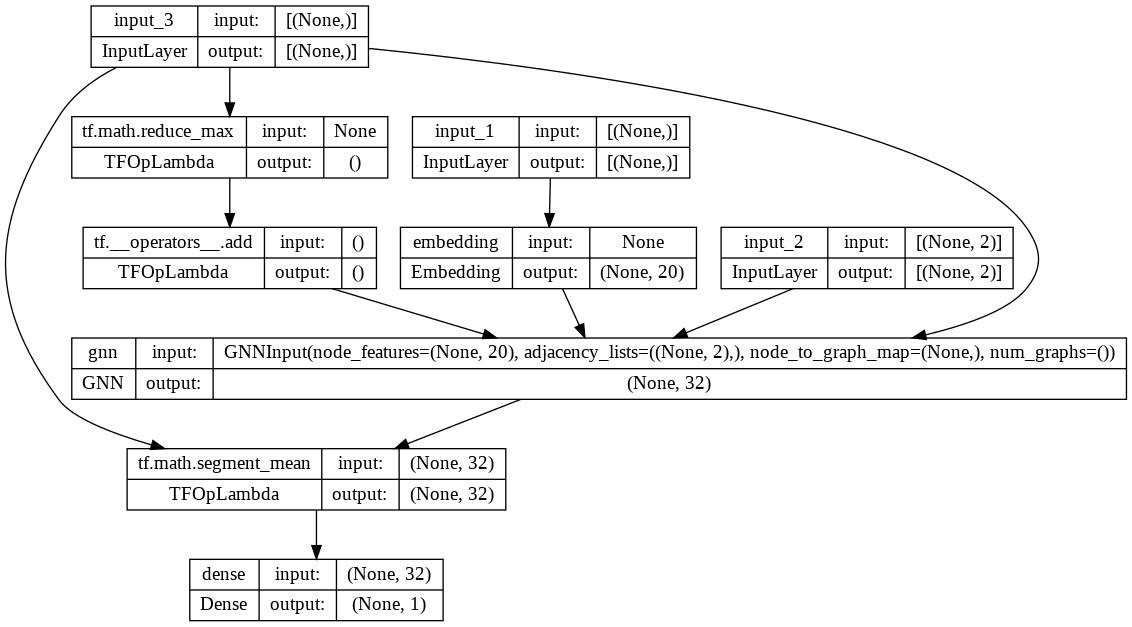

In [ ]:
tf.keras.utils.plot_model(model_T13, show_shapes=True)

In [ ]:
model_T13.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history_T13 = model_T13.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/loca

1330/1330 [==============================] - 20s 11ms/step - loss: 0.2300 - auc: 0.5059 - val_loss: 0.1964 - val_auc: 0.6349
Epoch 2/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1911 - auc: 0.6315 - val_loss: 0.1906 - val_auc: 0.6799
Epoch 3/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1860 - auc: 0.6641 - val_loss: 0.1888 - val_auc: 0.6883
Epoch 4/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1828 - auc: 0.6790 - val_loss: 0.1802 - val_auc: 0.7126
Epoch 5/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1827 - auc: 0.6756 - val_loss: 0.1903 - val_auc: 0.7095
Epoch 6/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1809 - auc: 0.6863 - val_loss: 0.1893 - val_auc: 0.7105
Epoch 7/10
1330/1330 [==============================] - 18s 13ms/step - loss: 0.1789 - auc: 0.6961 - val_loss: 0.1861 - val_auc: 0.7237
Epoch 8/10
1330/1330 [==============================] - 14s

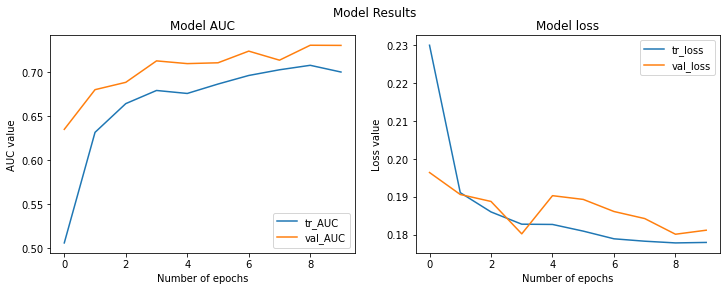

In [ ]:
plt_history_func(history_T13)

In [ ]:
y_pred = model_T13.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T13.csv')

##Trial_14 Using Graph Neural Networks with Feature-wise Linear Modulation

In [ ]:
from tf2_gnn.layers.message_passing import GNN_FiLM

In [ ]:
data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
embeded = Embedding(tokenizer.num_words, 20)(data)

num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = 'GNN_FiLM'
#params["num_layers"] = 4
params["num_heads"] = 3
params['film_parameter_MLP_hidden_layers'] = 12
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)   
print('pred:', pred)

# build our model and give it the inputs layers and the outputs layers
model_T14 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_T14.summary()
     

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

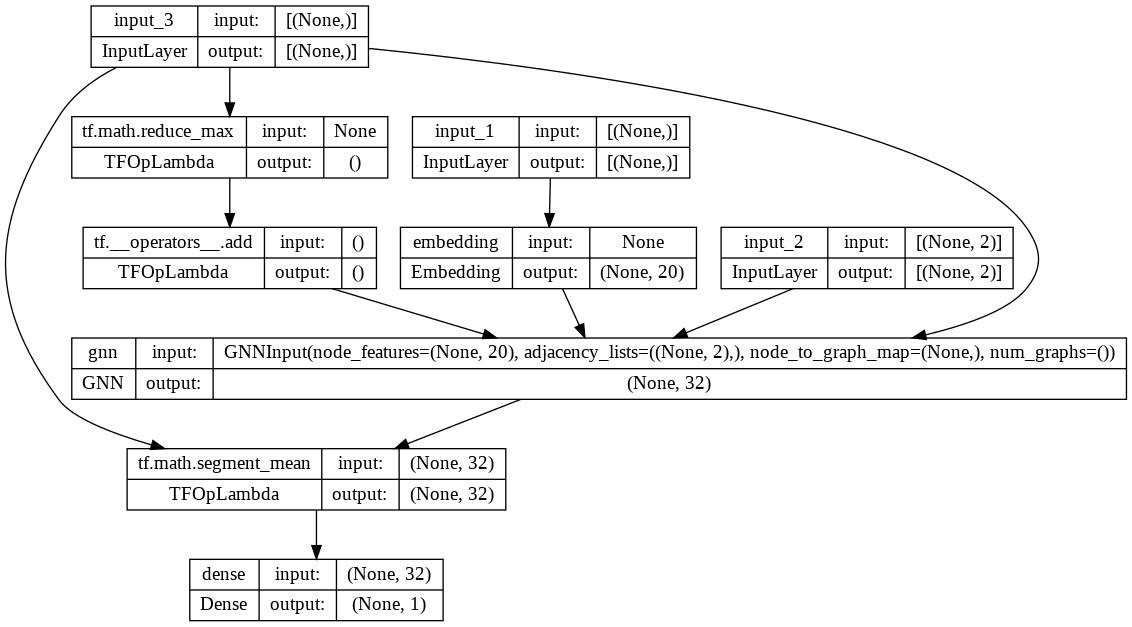

In [ ]:
tf.keras.utils.plot_model(model_T14, show_shapes=True)

In [ ]:
model_T14.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) 
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
%%time
history_T14 = model_T14.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,mode='max')],

)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/loca

1330/1330 [==============================] - 20s 11ms/step - loss: 0.2300 - auc: 0.5059 - val_loss: 0.1964 - val_auc: 0.6349
Epoch 2/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1911 - auc: 0.6315 - val_loss: 0.1906 - val_auc: 0.6799
Epoch 3/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1860 - auc: 0.6641 - val_loss: 0.1888 - val_auc: 0.6883
Epoch 4/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1828 - auc: 0.6790 - val_loss: 0.1802 - val_auc: 0.7126
Epoch 5/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1827 - auc: 0.6756 - val_loss: 0.1903 - val_auc: 0.7095
Epoch 6/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1809 - auc: 0.6863 - val_loss: 0.1893 - val_auc: 0.7105
Epoch 7/10
1330/1330 [==============================] - 18s 13ms/step - loss: 0.1789 - auc: 0.6961 - val_loss: 0.1861 - val_auc: 0.7237
Epoch 8/10
1330/1330 [==============================] - 14s

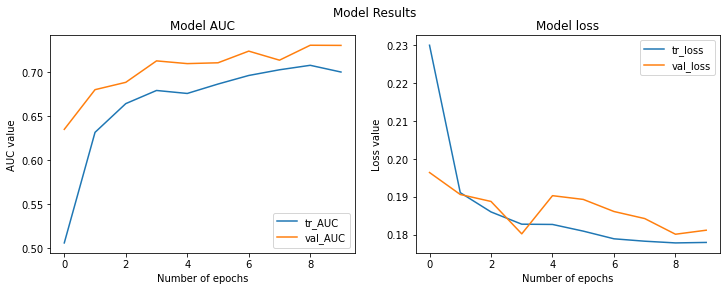

In [ ]:
plt_history_func(history_T14)

In [ ]:
y_pred = model_T14.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
# save the predictions in a csv file to submit it on Kaggle
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_T14.csv')